# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
from xopt import AsynchronousXopt as Xopt

In [2]:
# Helpers for this notebook
import multiprocessing
N_CPUS=multiprocessing.cpu_count()
N_CPUS

import os

# directory for data. 
os.makedirs("temp", exist_ok=True)

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

# Nicer plotting
%config InlineBackend.figure_format = 'retina'


The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """

max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.g41c35aa
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [4]:
%%timeit
# Check that the average time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

98.8 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 2min 1s, sys: 5.2 s, total: 2min 6s
Wall time: 3min 45s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 13.4 s, sys: 555 ms, total: 14 s
Wall time: 37.2 s


1000

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time
X = Xopt(YAML)

with ThreadPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 3.15 s, sys: 80.8 ms, total: 3.23 s
Wall time: 25.9 s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.dump('test.yaml') # Write this input to file
!cat test.yaml

data: null
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [11]:
%%time
!mpirun -n 8 python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2, asynchronous=True)
Parallel execution with 8 workers
Enabling async mode
Initialized generator cnsga
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2

            Xopt
________________________________
Version: 0+untagged.1.g41c35aa
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
   

In [12]:
!tail xopt.log

2023-12-16T02:41:17+0000 - xopt - INFO - Parallel execution with 8 workers
2023-12-16T02:41:17+0000 - xopt - INFO - Enabling async mode
2023-12-16T02:41:17+0000 - xopt.generator - INFO - Initialized generator cnsga
2023-12-16T02:41:17+0000 - xopt.generators.ga.cnsga - INFO - Created toolbox with 2 variables, 2 constraints, and 2 objectives.
2023-12-16T02:41:17+0000 - xopt.generators.ga.cnsga - INFO -     Using selection algorithm: nsga2
2023-12-16T02:41:40+0000 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42769,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:33199,Total threads: 1
Dashboard: http://127.0.0.1:37279/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:45073,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()
len(X.data)

CPU times: user 7.82 s, sys: 740 ms, total: 8.56 s
Wall time: 30.6 s


1000

# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,y1,y2,c1,c2,xopt_runtime,xopt_error
3,1.717556,2.478329,1.717556,2.478329,8.188447,5.396231,0.023045,False
1,3.017669,0.668294,3.017669,0.668294,8.647033,6.366980,0.039164,False
2,0.532749,0.033172,0.532749,0.033172,-0.769531,0.219001,0.102300,False
3,1.295312,1.519215,1.295312,1.519215,2.956237,1.671322,0.025592,False
4,2.934777,1.696339,2.934777,1.696339,10.541170,7.359367,0.089188,False
...,...,...,...,...,...,...,...,...
995,0.074731,0.991308,0.074731,0.991308,-0.047595,0.422237,0.078502,False
996,0.575399,0.917724,0.575399,0.917724,0.262712,0.180179,0.059928,False
997,0.787036,0.649573,0.787036,0.649573,0.036925,0.104762,0.193426,False
998,0.549229,0.449503,0.549229,0.449503,-0.494139,0.004973,0.031183,False


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,y1,y2,c1,c2,xopt_runtime,xopt_error,feasible_c1,feasible_c2,feasible
50,0.419371,1.091303,0.419371,1.091303,0.275223,0.356140,0.007970,False,True,True,True
52,1.145981,0.552747,1.145981,0.552747,0.557227,0.420073,0.077922,False,True,True,True
54,0.441361,1.034598,0.441361,1.034598,0.166607,0.289234,0.022131,False,True,True,True
73,0.653184,0.836967,0.653184,0.836967,0.165422,0.137012,0.158320,False,True,True,True
97,0.268623,0.991986,0.268623,0.991986,0.102476,0.295585,0.189619,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
991,0.421801,1.113640,0.421801,1.113640,0.329886,0.382669,0.050986,False,True,True,True
992,0.079922,1.018180,0.079922,1.018180,0.011864,0.444977,0.018357,False,True,True,True
994,0.549229,0.832719,0.549229,0.832719,0.094616,0.113126,0.014612,False,True,True,True
996,0.575399,0.917724,0.575399,0.917724,0.262712,0.180179,0.059928,False,True,True,True


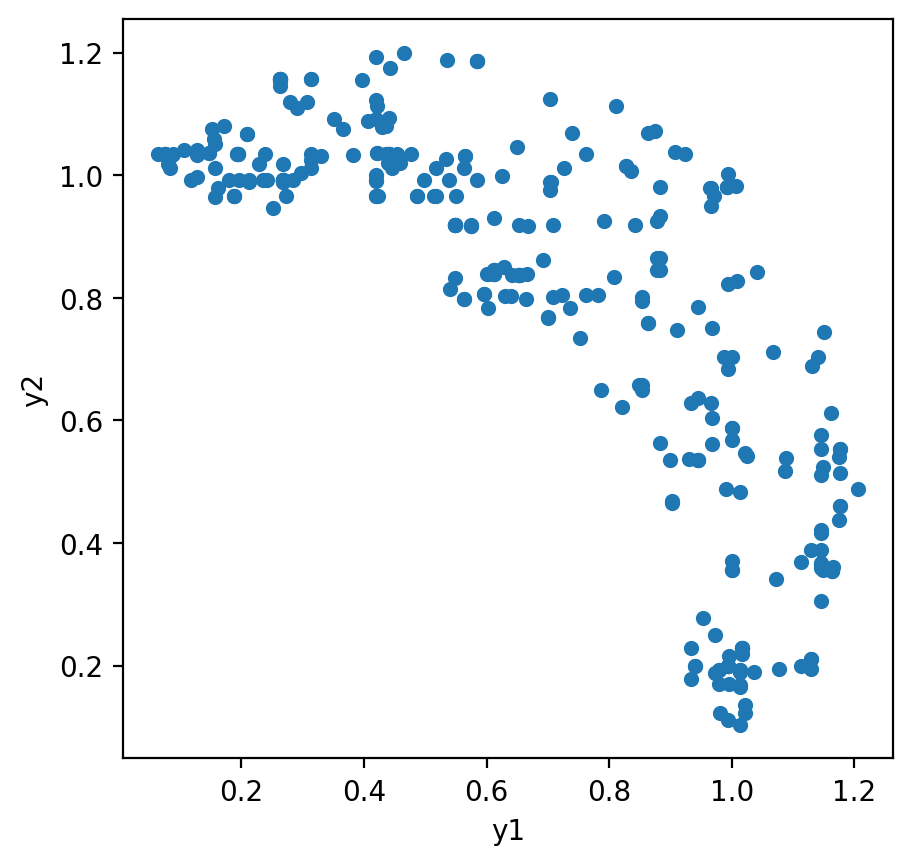

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

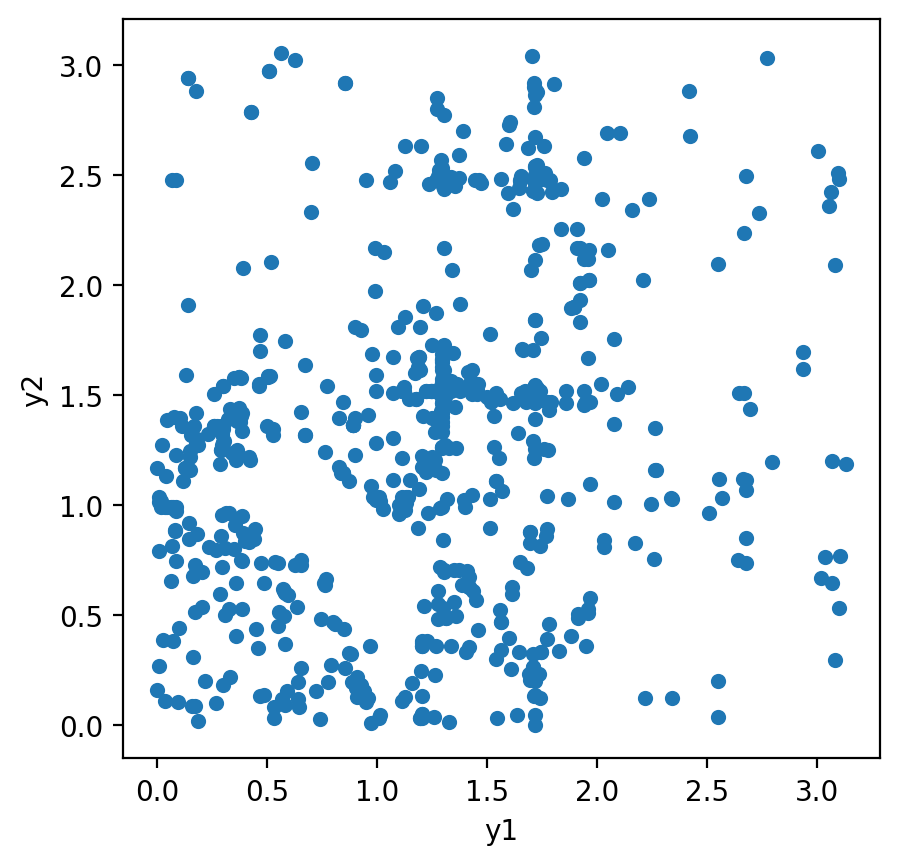

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

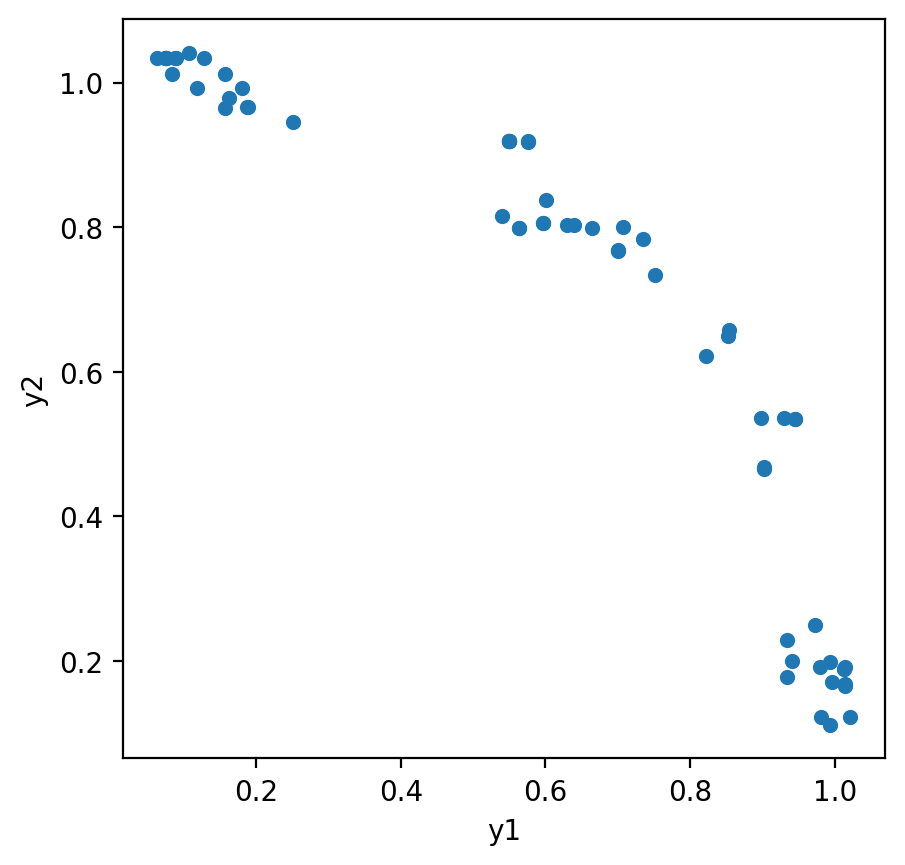

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

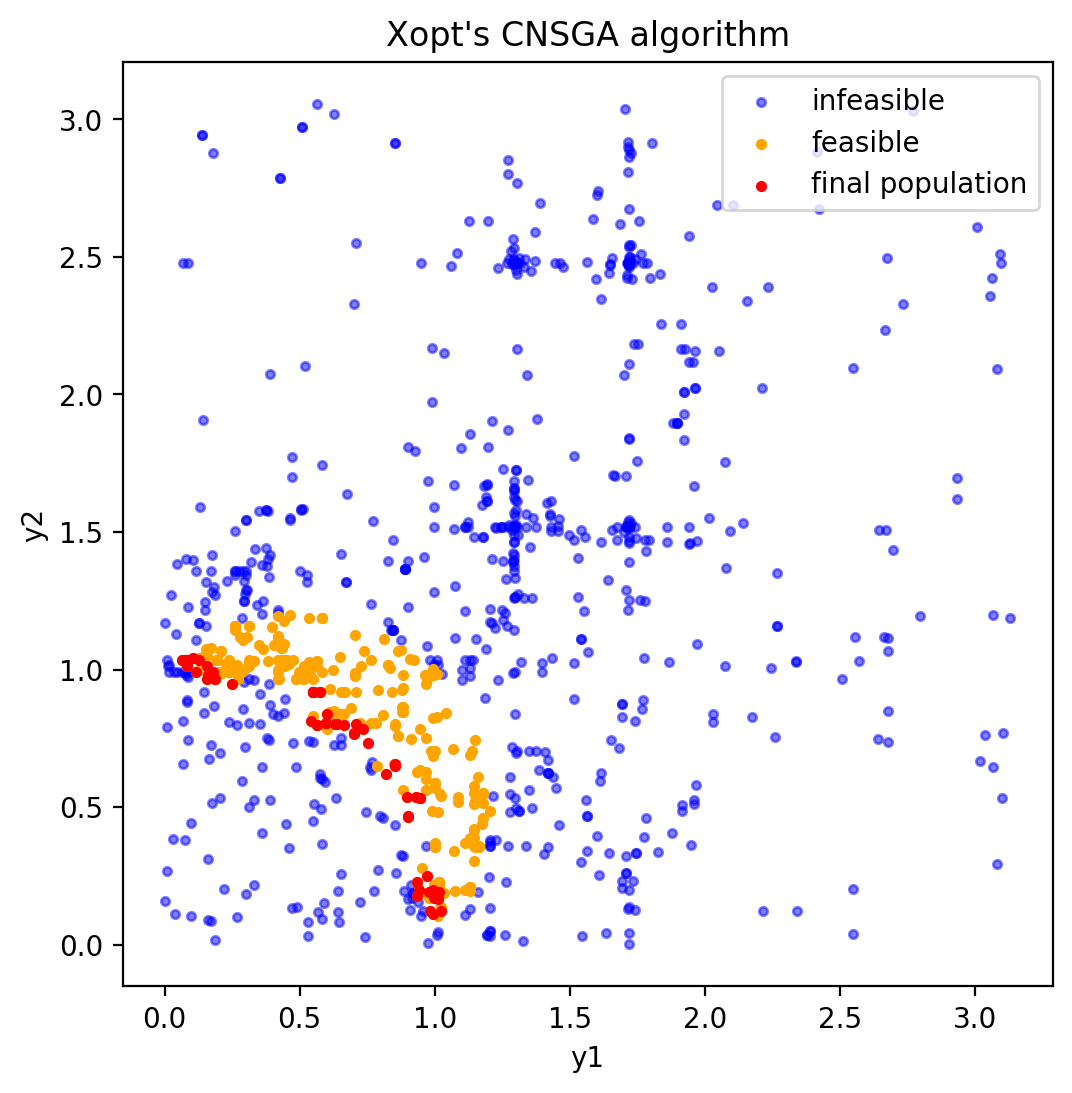

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
#!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml